In [1]:
# Import all the libraries needed
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import PIL
import random
import time
import os
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


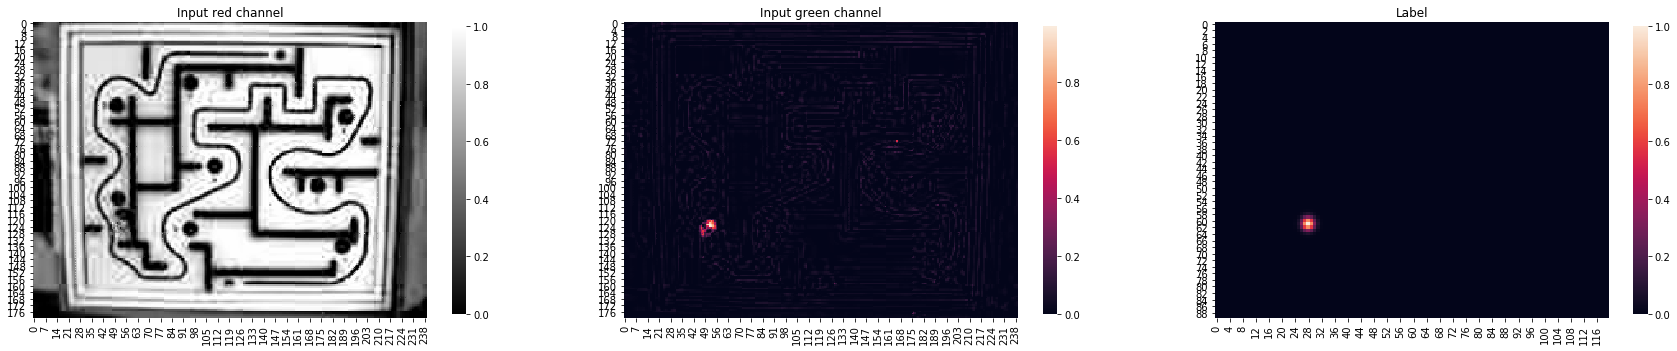

In [2]:
# Visualize the input of the CNN
fig = plt.figure(figsize = (30,30))
ax1 = fig.add_subplot(3, 3, 1)
ax1.set_title('Input red channel')
ax2 = fig.add_subplot(3, 3, 2)
ax2.set_title('Input green channel')
ax3 = fig.add_subplot(3, 3, 3)
ax3.set_title('Label')

x = np.load('Data/traindir/r_data/r_data-1900.npy')
y = np.load('Data/traindir/labels/label-1900.npy')
z = np.load('Data/traindir/g_data/g_data-1900.npy')
x = Image.fromarray(x.astype(np.uint8))
y = Image.fromarray(y.astype(np.uint8))
z = Image.fromarray(z.astype(np.uint8))

x = TF.to_tensor(x)
y = TF.to_tensor(y)
z = TF.to_tensor(z)


sns.heatmap(x[0], cmap='gray', ax=ax1, square=True, cbar_kws={'shrink': .6})
sns.heatmap(z[0], ax=ax2, square=True, cbar_kws={'shrink': .6})
sns.heatmap(y[0], ax=ax3, square=True, cbar_kws={'shrink': .6})
plt.show()

In [3]:
input_width = 240
input_height = 180

output_width = 120
output_height = 90

# Tell the dataloader where to search and where to put the arrays
traindir = 'Data/traindir'
train_channels = [f'{traindir}/r_data', f'{traindir}/g_data']

valdir = 'Data/valdir'
val_channels = [f'{valdir}/r_data', f'{valdir}/g_data']

testdir = 'Data/testdir'
test_channels = [f'{testdir}/r_data', f'{testdir}/g_data']

train_inputs = []
train_labels = []

val_inputs = []
val_labels = []

test_inputs = []
test_labels = []




# Load the saved .npy arrays from the preprocessing.py file into the above arrays,
# split up the red and green channel again so that the axes match in size
def load_npy_arrays(phase):
    
    if phase == "train":
        phase_channels = train_channels
        phase_inputs = train_inputs
        phasedir = traindir
        phase_labels = train_labels
    
    elif phase == "val":
        phase_channels = val_channels
        phase_inputs = val_inputs
        phasedir = valdir
        phase_labels = val_labels
    
    elif phase == "test":
        phase_channels = test_channels
        phase_inputs = test_inputs
        phasedir = testdir
        phase_labels = test_labels
    
    else:
        print('Valueerror: please pass one of the three accepted strings("train", "val", "test")')

    for channel in phase_channels:
        path_to_channel = channel
        for file in sorted(os.listdir(channel)):
            filename = file
            if filename.endswith('.npy'):
                loaded_array = np.load(f'{path_to_channel}/{filename}')
                phase_inputs.append(loaded_array)
                continue
            else:
                continue
                
    labelfolder = f'{phasedir}/labels'
    for file in sorted(os.listdir(labelfolder)):
        filename = file
        if filename.endswith('.npy'):
            loaded_array = np.load(f'{labelfolder}/{filename}')
            phase_labels.append(loaded_array)
            continue
        else:
            continue
    print(np.shape(phase_labels))

load_npy_arrays("train")
load_npy_arrays("val")
load_npy_arrays("test")

train_inputs = np.asarray(train_inputs)
train_inputs = np.split(train_inputs, 2, axis=0)
train_inputs = np.asarray(train_inputs).transpose(1,0,2,3)
print(np.shape(train_inputs))

val_inputs = np.asarray(val_inputs)
val_inputs = np.split(val_inputs, 2, axis=0)
val_inputs = np.asarray(val_inputs).transpose(1,0,2,3)
print(np.shape(val_inputs))

test_inputs = np.asarray(test_inputs)
test_inputs = np.split(test_inputs, 2, axis=0)
test_inputs = np.asarray(test_inputs).transpose(1,0,2,3)
print(np.shape(test_inputs))

train_labels = np.asarray(train_labels)
val_labels = np.asarray(val_labels)
test_labels = np.asarray(test_labels)


# Define our own dataset creator because we want to load numpy arrays,
# but still be able to apply transformations as if it were images
class CreateDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.FloatTensor(inputs)
        self.labels = torch.FloatTensor(labels)
        
    def __getitem__(self, index):
        x = self.inputs[index]
        y = self.labels[index]
        
        xred = x[0]
        xgreen = x[1]
        
        xred = Image.fromarray(xred.numpy().astype(np.uint8))
        xgreen = Image.fromarray(xgreen.numpy().astype(np.uint8))
        y = Image.fromarray(self.labels[index].numpy().astype(np.uint8))
        
        if random.random() > 0.5:
            xred = TF.hflip(xred)
            xgreen = TF.hflip(xgreen)
            y = TF.hflip(y)
            
        if random.random() > 0.5:
            xred = TF.vflip(xred)
            xgreen = TF.vflip(xgreen)
            y = TF.vflip(y)
            
        if random.random() > 0.5: 
            angle = random.randint(-180, 180)
            
            xred = TF.resize(xred, (input_height*2,input_width*2), interpolation=2)
            xgreen = TF.resize(xgreen, (input_height*2,input_width*2), interpolation=2)
            y = TF.resize(y, (output_height*2,output_width*2), interpolation=2)
            
            filler = 0.0 if xred.mode.startswith("F") else 0
            num_bands = len(xred.getbands())
            xred = TF.rotate(xred, angle, fill=tuple([filler]*num_bands))
            
            filler = 0.0 if xgreen.mode.startswith("F") else 0
            num_bands = len(xgreen.getbands())
            xgreen = TF.rotate(xgreen, angle, fill=tuple([filler]*num_bands))
            
            filler = 0.0 if y.mode.startswith("F") else 0
            num_bands = len(y.getbands())
            y = TF.rotate(y, angle, fill=tuple([filler]*num_bands))
            
            xred = TF.resize(xred, (input_height,input_width), interpolation=2)
            xgreen = TF.resize(xgreen, (input_height,input_width), interpolation=2)
            y = TF.resize(y, (output_height,output_width), interpolation=2)
        
        xred = TF.to_tensor(xred)
        xgreen = TF.to_tensor(xgreen)
        y = TF.to_tensor(y)
        
        x[0] = xred
        x[1] = xgreen
        
        return x, y

    def __len__(self):
        return len(self.inputs)

    
# Get the data, transform it
data = {
   'train':
   CreateDataset(train_inputs, train_labels),
   'val':
   CreateDataset(val_inputs, val_labels),
    'test':
   CreateDataset(test_inputs, test_labels),
}


batch_size = 1
print('Sum of all labels in a batch: ' ,batch_size*np.sum(train_labels[0]/255))

# Load Data in batches, shuffled
dataloaders = {
   'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, drop_last=True),
   'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True, drop_last=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True, drop_last=True),
}

(1546, 90, 120)
(284, 90, 120)
(330, 90, 120)
(1546, 2, 180, 240)
(284, 2, 180, 240)
(330, 2, 180, 240)
Sum of all labels in a batch:  11.341149479456016


In [4]:
# Define the FCN for cue ball detection and tracking

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(2,16,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Sigmoid(),
            nn.BatchNorm2d(16))
    
        self.layer2 = nn.Sequential( 
            nn.Conv2d(16,32,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Sigmoid(),
            nn.BatchNorm2d(32),
            nn.MaxPool3d((1,2,2), padding=0))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.Sigmoid(),
            nn.BatchNorm2d(64))

        self.layer4 = nn.Sequential(
            nn.Conv2d(64,1,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1),
            nn.Sigmoid())

    def forward(self,x):
        x = self.layer1(x)  
        x = self.layer2(x)  
        x = self.layer3(x)  
        x = self.layer4(x)  
        return x

In [5]:
# Check if GPU is available and move the model over to GPU
if torch.cuda.is_available():
    device = torch.device("cuda: 0")
    gpu_name = torch.cuda.get_device_name()
    print(f"Running on your {gpu_name} (GPU)")
else:
    device = torch.device("cpu")
    print("Running on your CPU")

net = CNN().to(device)

Running on your GeForce GTX 970M (GPU)


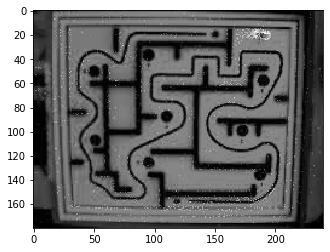

In [6]:
writer = SummaryWriter('Tensorboard')
train_inputs, train_labels = next(iter(dataloaders['train']))
img_grid = torchvision.utils.make_grid(train_inputs)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="gray")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

matplotlib_imshow(img_grid, one_channel=True)
writer.add_image('labi_images', img_grid)
writer.add_graph(net, train_inputs.to(device))
writer.close()

In [7]:
# Define the training loop with loss-function and optimizer

loss_fn = nn.L1Loss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 1
epochs_no_improve_limit = 7

train_losses = []
val_losses = []


def train():
    epochs_no_improve = 0
    min_val_loss = np.Inf
    since = time.time()
    iteration = 0
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
        val_loss = 0
        
        for train_inputs, train_labels in dataloaders['train']:
            optimizer.zero_grad()
            output = net(train_inputs.to(device)).reshape(batch_size, output_height, output_width)
            loss = loss_fn(output.cpu(), train_labels.cpu().reshape(batch_size, output_height, output_width))
            
#             fig = plt.figure(figsize = (32,24))
#             ax1 = fig.add_subplot(2, 2, 1)
#             ax1.set_title('Input red')
#             ax2 = fig.add_subplot(2, 2, 2)
#             ax2.set_title('Input green')
#             ax3 = fig.add_subplot(2, 2, 3)
#             ax3.set_title('Label')
#             ax4 = fig.add_subplot(2, 2, 4)
#             ax4.set_title('Output of the CNN')

#             sns.heatmap(train_inputs[0][0], vmin=0, vmax=1, cmap='gray', ax=ax1, cbar_kws={'shrink': .9})
#             sns.heatmap(train_inputs[0][1], vmin=0, vmax=1, ax=ax2, cbar_kws={'shrink': .9})
#             sns.heatmap(train_labels[0][0], vmin=0, vmax=1, ax=ax3, cbar_kws={'shrink': .9})
#             sns.heatmap(output.cpu().detach().numpy()[0], vmin=0, vmax=1, ax=ax4, cbar_kws={'shrink': .9})
#             plt.show()
            writer.add_scalar('Loss/train', loss, iteration)
            train_losses.append(float(loss))
            print('Training Loss: {:.4f}'.format(loss.item()))
            loss.backward()
            optimizer.step()
            iteration += 1
        
        del train_inputs
        del train_labels
        del output
        del loss
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            for val_inputs, val_labels in dataloaders['val']:
                torch.cuda.empty_cache()
                output = net(val_inputs.to(device)).reshape(batch_size, output_height, output_width)
                loss = loss_fn(output.cpu(), val_labels.cpu().reshape(batch_size, output_height, output_width))
                val_loss += loss

            val_loss = val_loss / len(dataloaders['val'])
            val_losses.append(float(val_loss))
            print('-' * 10)
            print('Validation Loss: {:.4f}'.format(val_loss))

            if val_loss < min_val_loss:
                torch.save(net, 'Nets/pt-labi_CNN.pt')
                epochs_no_improve = 0
                min_val_loss = val_loss
            else:
                epochs_no_improve += 1
                if epochs_no_improve == epochs_no_improve_limit:
                    print('Early stopping initiated')
                    model = torch.load('Nets/pt-labi_CNN.pt')
                    print('Best model so far has been loaded')
    print('Least validation Loss: {:4f}'.format(min_val_loss))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Finished training')
train()

Epoch 1/6
----------
Training Loss: 5491.0508
Training Loss: 5300.1987
Training Loss: 5298.7202
Training Loss: 5296.8101
Training Loss: 5314.4404
Training Loss: 5274.4165
Training Loss: 5287.4780
Training Loss: 5252.0669
Training Loss: 5280.3179
Training Loss: 5249.4126
Training Loss: 5241.6621
Training Loss: 5256.7617
Training Loss: 5236.4106
Training Loss: 5242.9277
Training Loss: 5225.7837
Training Loss: 5212.1919
Training Loss: 5215.0322
Training Loss: 5205.8516
Training Loss: 5192.1880
Training Loss: 5201.1484
Training Loss: 5190.4038
Training Loss: 5189.9385
Training Loss: 5196.8628
Training Loss: 5210.8188
Training Loss: 5187.1021
Training Loss: 5168.4248
Training Loss: 5221.3447
Training Loss: 5191.9834
Training Loss: 5167.9194
Training Loss: 5168.1680
Training Loss: 5199.4175
Training Loss: 5185.6030
Training Loss: 5184.6279
Training Loss: 5157.3848
Training Loss: 5140.5552
Training Loss: 5129.4014
Training Loss: 5120.1401
Training Loss: 5123.1484
Training Loss: 5130.5439
Trai

Training Loss: 4175.4785
Training Loss: 4118.0186
Training Loss: 4112.4976
Training Loss: 4110.9004
Training Loss: 4106.7427
Training Loss: 4157.0161
Training Loss: 4101.6680
Training Loss: 4093.4988
Training Loss: 4131.9043
Training Loss: 4094.4844
Training Loss: 4099.2168
Training Loss: 4096.0435
Training Loss: 4096.9717
Training Loss: 4129.3086
Training Loss: 4075.6987
Training Loss: 4131.8247
Training Loss: 4129.9810
Training Loss: 4117.0854
Training Loss: 4083.9084
Training Loss: 4194.3535
Training Loss: 4204.9980
Training Loss: 4186.3901
Training Loss: 4183.8218
Training Loss: 4051.6187
Training Loss: 4057.3523
Training Loss: 4157.6406
Training Loss: 4044.7300
Training Loss: 4047.2886
Training Loss: 4071.4573
Training Loss: 4189.2329
Training Loss: 4092.4568
Training Loss: 4076.1072
Training Loss: 4092.9253
Training Loss: 4060.9792
Training Loss: 4131.8940
Training Loss: 4147.2739
Training Loss: 4015.6167
Training Loss: 4019.7498
Training Loss: 4030.9282
Training Loss: 4021.7866


Training Loss: 3474.5049
Training Loss: 3316.8525
Training Loss: 3316.4258
Training Loss: 3445.8005
Training Loss: 3535.9263
Training Loss: 3335.1248
Training Loss: 3345.3777
Training Loss: 3314.1262
Training Loss: 3439.6899
Training Loss: 3332.6423
Training Loss: 3330.3787
Training Loss: 3469.4500
Training Loss: 3546.0791
Training Loss: 3425.7720
Training Loss: 3299.1416
Training Loss: 3339.9026
Training Loss: 3346.9038
Training Loss: 3305.6799
Training Loss: 3419.0344
Training Loss: 3291.0430
Training Loss: 3298.4600
Training Loss: 3306.1570
Training Loss: 3352.7251
Training Loss: 3296.9509
Training Loss: 3526.9968
Training Loss: 3415.3660
Training Loss: 3318.5168
Training Loss: 3296.2283
Training Loss: 3394.4216
Training Loss: 3314.5098
Training Loss: 3383.4761
Training Loss: 3283.2419
Training Loss: 3462.1497
Training Loss: 3279.8687
Training Loss: 3402.1333
Training Loss: 3390.8667
Training Loss: 3283.2471
Training Loss: 3259.2563
Training Loss: 3235.2275
Training Loss: 3244.2437


Training Loss: 2889.0093
Training Loss: 2884.3547
Training Loss: 2701.6650
Training Loss: 2695.0710
Training Loss: 2870.9761
Training Loss: 2680.9907
Training Loss: 2687.0413
Training Loss: 2697.7354
Training Loss: 2671.6875
Training Loss: 2678.8660
Training Loss: 2889.6472
Training Loss: 3051.0657
Training Loss: 2681.7593
Training Loss: 2670.7168
Training Loss: 2877.4724
Training Loss: 2754.7905
Training Loss: 2700.1765
Training Loss: 2666.9656
Training Loss: 2859.6033
Training Loss: 2872.8308
Training Loss: 2910.5281
Training Loss: 2713.9358
Training Loss: 2680.4075
Training Loss: 2980.5691
Training Loss: 2645.0710
Training Loss: 2660.7693
Training Loss: 2647.8992
Training Loss: 2701.4163
Training Loss: 2844.5229
Training Loss: 2818.2876
Training Loss: 2707.4045
Training Loss: 2669.1313
Training Loss: 2665.5784
Training Loss: 3039.4492
Training Loss: 2941.4199
Training Loss: 2865.4097
Training Loss: 2666.4561
Training Loss: 2687.8347
Training Loss: 2645.8225
Training Loss: 2726.5813


Training Loss: 2231.3076
Training Loss: 2439.5356
Training Loss: 2226.6050
Training Loss: 2222.2966
Training Loss: 2245.8599
Training Loss: 2569.7090
Training Loss: 2233.3149
Training Loss: 2230.4062
Training Loss: 2226.9678
Training Loss: 2294.4534
Training Loss: 2267.1245
Training Loss: 2432.0911
Training Loss: 2276.2163
Training Loss: 2253.1099
Training Loss: 2241.2585
Training Loss: 2215.3064
Training Loss: 2211.9504
Training Loss: 2243.3840
Training Loss: 2518.9363
Training Loss: 2375.9011
Training Loss: 2226.7627
Training Loss: 2205.8301
Training Loss: 2240.2561
Training Loss: 2203.2739
Training Loss: 2237.5618
Training Loss: 2191.1455
Training Loss: 2198.1074
Training Loss: 2204.8931
Training Loss: 2193.7412
Training Loss: 2188.5608
Training Loss: 2244.6240
Training Loss: 2200.9236
Training Loss: 2194.2046
Training Loss: 2530.5322
Training Loss: 2707.8152
Training Loss: 2749.3528
Training Loss: 2182.5945
Training Loss: 2610.9495
Training Loss: 2179.2368
Training Loss: 2704.2681


C:\Users\fabia\anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Training Loss: 3219.4094
Training Loss: 2069.8389
Training Loss: 2045.8385
Training Loss: 3949.0376
Training Loss: 2114.2522
Training Loss: 3990.6431
Training Loss: 3985.9937
Training Loss: 2129.3081
Training Loss: 2115.5454
Training Loss: 2151.1626
Training Loss: 3836.6809
Training Loss: 2019.4135
Training Loss: 2006.3007
Training Loss: 3622.3713
Training Loss: 1989.3771
Training Loss: 2096.5532
Training Loss: 2000.9291
Training Loss: 2725.1294
Training Loss: 2047.6117
Training Loss: 2614.1748
Training Loss: 1986.9573
Training Loss: 2694.7134
Training Loss: 2314.5811
Training Loss: 1943.5806
Training Loss: 2188.2979
Training Loss: 1910.3851
Training Loss: 2000.4672
Training Loss: 2059.4282
Training Loss: 1914.0305
Training Loss: 1899.4902
Training Loss: 2149.3967
Training Loss: 2029.8473
Training Loss: 1980.7192
Training Loss: 1923.3220
Training Loss: 1923.9049
Training Loss: 1927.2559
Training Loss: 1905.7201
Training Loss: 1911.1072
Training Loss: 2164.7676
Training Loss: 1888.7507

Training Loss: 1596.0216
Training Loss: 1598.0111
Training Loss: 1594.9323
Training Loss: 1592.9177
Training Loss: 1592.3779
Training Loss: 1591.7166
Training Loss: 1595.4586
Training Loss: 1591.4248
Training Loss: 1589.1227
Training Loss: 1588.3810
Training Loss: 1590.2205
Training Loss: 1587.0675
Training Loss: 1586.2566
Training Loss: 1585.2581
Training Loss: 1587.8444
Training Loss: 1583.6234
Training Loss: 1581.6689
Training Loss: 1581.8137
Training Loss: 1583.0864
Training Loss: 1581.5804
Training Loss: 1575.8278
Training Loss: 1578.7223
Training Loss: 1578.6752
Training Loss: 1577.8068
Training Loss: 1577.1876
Training Loss: 1581.5371
Training Loss: 1575.2745
Training Loss: 1573.2974
Training Loss: 1574.1636
Training Loss: 1572.8467
Training Loss: 1570.4050
Training Loss: 1570.0980
Training Loss: 1571.9298
Training Loss: 1571.0852
Training Loss: 1568.9546
Training Loss: 1564.1934
Training Loss: 1567.8715
Training Loss: 1566.6731
Training Loss: 1565.5826
Training Loss: 1564.0865


Training Loss: 1370.3563
Training Loss: 1370.5369
Training Loss: 1366.0322
Training Loss: 1368.3258
Training Loss: 1369.7258
Training Loss: 1367.1786
Training Loss: 1367.5232
Training Loss: 1367.6128
Training Loss: 1366.3789
Training Loss: 1365.8389
Training Loss: 1365.2500
Training Loss: 1363.7528
Training Loss: 1357.3595
Training Loss: 1362.5570
Training Loss: 1363.5360
Training Loss: 1363.0375
Training Loss: 1362.4115
Training Loss: 1358.9681
Training Loss: 1362.4801
Training Loss: 1360.7559
Training Loss: 1359.4834
Training Loss: 1359.7086
Training Loss: 1358.3737
Training Loss: 1356.9282
Training Loss: 1357.0645
Training Loss: 1355.7612
Training Loss: 1355.9755
Training Loss: 1353.1519
Training Loss: 1354.5927
Training Loss: 1354.9352
Training Loss: 1354.2736
Training Loss: 1352.8369
Training Loss: 1353.6123
Training Loss: 1352.5305
Training Loss: 1351.4900
Training Loss: 1351.7557
Training Loss: 1349.3958
Training Loss: 1350.8545
Training Loss: 1350.0194
Training Loss: 1347.6978


Training Loss: 1204.4954
Training Loss: 1203.4834
Training Loss: 1202.4045
Training Loss: 1203.1195
Training Loss: 1202.2192
Training Loss: 1201.8811
Training Loss: 1199.9379
Training Loss: 1200.3029
Training Loss: 1200.6150
Training Loss: 1199.3694
Training Loss: 1198.2435
Training Loss: 1198.5206
Training Loss: 1197.3038
Training Loss: 1198.2616
Training Loss: 1196.7992
Training Loss: 1195.9578
Training Loss: 1195.6451
Training Loss: 1196.3794
Training Loss: 1196.0200
Training Loss: 1194.2765
Training Loss: 1195.0482
Training Loss: 1194.5334
Training Loss: 1193.4338
Training Loss: 1193.2487
Training Loss: 1192.4729
Training Loss: 1191.5569
Training Loss: 1191.1259
Training Loss: 1191.5188
Training Loss: 1191.4917
Training Loss: 1191.1671
Training Loss: 1190.4778
Training Loss: 1189.3834
Training Loss: 1188.5282
Training Loss: 1189.0038
Training Loss: 1188.0352
Training Loss: 1188.8281
Training Loss: 1187.6177
Training Loss: 1186.0375
Training Loss: 1185.9641
Training Loss: 1186.7346


Training Loss: 1074.1747
Training Loss: 1073.3889
Training Loss: 1073.4398
Training Loss: 1073.3221
Training Loss: 1072.7729
Training Loss: 1072.6722
Training Loss: 1072.4254
Training Loss: 1071.9362
Training Loss: 1071.5930
Training Loss: 1071.2675
Training Loss: 1070.6447
Training Loss: 1063.7122
Training Loss: 1069.3833
Training Loss: 1070.1041
Training Loss: 1063.2567
Training Loss: 1069.0703
Training Loss: 1068.9463
Training Loss: 1068.3777
Training Loss: 1068.0646
Training Loss: 1067.1938
Training Loss: 1067.3723
Training Loss: 1067.3090
Training Loss: 1066.7019
Training Loss: 1066.6051
Training Loss: 1065.6921
Training Loss: 1065.4777
Training Loss: 1065.3024
Training Loss: 1064.9843
Training Loss: 1060.8362
Training Loss: 1064.3973
Training Loss: 1062.4921
Training Loss: 1063.0436
Training Loss: 1063.4471
Training Loss: 1062.3794
Training Loss: 1063.0277
Training Loss: 1062.4674
Training Loss: 1062.3489
Training Loss: 1061.9227
Training Loss: 1061.3718
Training Loss: 1060.8981


Training Loss: 972.2220
Training Loss: 972.6266
Training Loss: 965.1156
Training Loss: 971.4575
Training Loss: 971.8268
Training Loss: 970.8827
Training Loss: 971.2932
Training Loss: 971.0275
Training Loss: 970.7635
Training Loss: 970.4947
Training Loss: 969.4681
Training Loss: 969.9647
Training Loss: 969.7040
Training Loss: 969.4386
Training Loss: 962.2319
Training Loss: 968.2358
Training Loss: 968.6525
Training Loss: 968.3866
Training Loss: 960.5243
Training Loss: 965.4737
Training Loss: 958.5176
Training Loss: 967.3286
Training Loss: 967.0704
Training Loss: 966.8076
Training Loss: 965.3614
Training Loss: 966.2804
Training Loss: 966.0170
Training Loss: 965.7512
Training Loss: 964.7906
Training Loss: 958.0322
Training Loss: 964.3657
Training Loss: 964.6985
Training Loss: 963.6014
Training Loss: 963.5078
Training Loss: 963.2203
Training Loss: 962.9730
Training Loss: 962.6819
Training Loss: 963.1306
Training Loss: 962.1904
Training Loss: 961.9853
Training Loss: 962.3512
Training Loss: 9

Training Loss: 890.6791
Training Loss: 890.4689
Training Loss: 890.2566
Training Loss: 890.0463
Training Loss: 889.1888
Training Loss: 888.9568
Training Loss: 889.4154
Training Loss: 889.2043
Training Loss: 888.9958
Training Loss: 888.1406
Training Loss: 887.9579
Training Loss: 887.7374
Training Loss: 887.4673
Training Loss: 887.3186
Training Loss: 887.0941
Training Loss: 887.5292
Training Loss: 886.6392
Training Loss: 887.1131
Training Loss: 886.9052
Training Loss: 886.1121
Training Loss: 885.9183
Training Loss: 885.6780
Training Loss: 886.0737
Training Loss: 885.2672
Training Loss: 885.6584
Training Loss: 885.4524
Training Loss: 885.2438
Training Loss: 884.4318
Training Loss: 884.8298
Training Loss: 883.9836
Training Loss: 884.4170
Training Loss: 883.6662
Training Loss: 884.0044
Training Loss: 883.1602
Training Loss: 883.0002
Training Loss: 883.3835
Training Loss: 882.5930
Training Loss: 882.9745
Training Loss: 882.7681
Training Loss: 881.8922
Training Loss: 882.3562
Training Loss: 8

Training Loss: 825.6380
Training Loss: 817.9940
Training Loss: 825.8555
Training Loss: 825.1663
Training Loss: 824.9188
Training Loss: 824.8422
Training Loss: 824.6171
Training Loss: 824.5451
Training Loss: 824.2870
Training Loss: 824.6774
Training Loss: 824.5079
Training Loss: 824.3414
Training Loss: 824.1710
Training Loss: 824.0032
Training Loss: 823.8381
Training Loss: 823.0511
Training Loss: 822.9706
Training Loss: 823.3347
Training Loss: 823.1646
Training Loss: 822.9999
Training Loss: 822.2958
Training Loss: 822.1009
Training Loss: 822.4981
Training Loss: 821.8120
Training Loss: 822.1640
Training Loss: 821.9998
Training Loss: 821.8335
Training Loss: 821.6655
Training Loss: 821.4979
Training Loss: 821.3333
Training Loss: 820.6191
Training Loss: 820.4879
Training Loss: 820.2473
Training Loss: 820.6661
Training Loss: 820.5042
Training Loss: 820.3395
Training Loss: 820.1696
Training Loss: 820.0067
Training Loss: 819.8420
Training Loss: 819.6761
Training Loss: 815.8583
Training Loss: 8

Training Loss: 773.7237
Training Loss: 773.4952
Training Loss: 773.8953
Training Loss: 773.3060
Training Loss: 773.6226
Training Loss: 773.0959
Training Loss: 772.8719
Training Loss: 764.6310
Training Loss: 773.0724
Training Loss: 772.5417
Training Loss: 772.8007
Training Loss: 772.3301
Training Loss: 772.0527
Training Loss: 772.3928
Training Loss: 771.8171
Training Loss: 772.1218
Training Loss: 771.5302
Training Loss: 771.8459
Training Loss: 771.2916
Training Loss: 771.5770
Training Loss: 770.9835
Training Loss: 771.3049
Training Loss: 771.1689
Training Loss: 771.0316
Training Loss: 770.8964
Training Loss: 770.3009
Training Loss: 770.1900
Training Loss: 770.4934
Training Loss: 769.8721
Training Loss: 760.0934
Training Loss: 770.0891
Training Loss: 769.4613
Training Loss: 769.8177
Training Loss: 769.6836
Training Loss: 769.5515
Training Loss: 768.9519
Training Loss: 769.2823
Training Loss: 760.2639
Training Loss: 769.0131
Training Loss: 768.4459
Training Loss: 768.2995
Training Loss: 7

Training Loss: 730.3632
Training Loss: 720.4299
Training Loss: 730.5750
Training Loss: 730.4686
Training Loss: 722.5671
Training Loss: 729.9828
Training Loss: 730.1358
Training Loss: 730.0198
Training Loss: 729.9105
Training Loss: 729.7999
Training Loss: 729.3051
Training Loss: 729.5751
Training Loss: 729.4604
Training Loss: 728.9879
Training Loss: 728.8517
Training Loss: 728.7225
Training Loss: 728.6202
Training Loss: 728.9116
Training Loss: 728.8000
Training Loss: 728.6906
Training Loss: 728.2056
Training Loss: 728.4699
Training Loss: 728.3567
Training Loss: 727.8706
Training Loss: 728.1375
Training Loss: 727.6769
Training Loss: 727.9189
Training Loss: 727.2378
Training Loss: 727.6959
Training Loss: 727.0970
Training Loss: 718.5302
Training Loss: 726.9551
Training Loss: 726.8049
Training Loss: 726.7568
Training Loss: 727.0368
Training Loss: 726.5370
Training Loss: 726.8226
Training Loss: 726.3382
Training Loss: 726.2382
Training Loss: 726.1801
Training Loss: 726.0149
Training Loss: 7

Training Loss: 695.5338
Training Loss: 695.7358
Training Loss: 695.1943
Training Loss: 695.5540
Training Loss: 695.4607
Training Loss: 695.3679
Training Loss: 694.9141
Training Loss: 694.0842
Training Loss: 690.8171
Training Loss: 694.6995
Training Loss: 694.5473
Training Loss: 694.8281
Training Loss: 694.7350
Training Loss: 694.6435
Training Loss: 694.1574
Training Loss: 694.0767
Training Loss: 694.0212
Training Loss: 693.8506
Training Loss: 694.1823
Training Loss: 694.0936
Training Loss: 693.6039
Training Loss: 693.5336
Training Loss: 693.8209
Training Loss: 693.7266
Training Loss: 693.6367
Training Loss: 693.5491
Training Loss: 689.0165
Training Loss: 693.3671
Training Loss: 692.8820
Training Loss: 693.1912
Training Loss: 693.1000
Training Loss: 692.5731
Training Loss: 692.5974
Training Loss: 692.8265
Training Loss: 692.4031
Training Loss: 692.6464
Training Loss: 692.1913
Training Loss: 692.4633
Training Loss: 692.0427
Training Loss: 691.7325
Training Loss: 684.9112
Training Loss: 6

Training Loss: 666.5959
Training Loss: 666.5633
Training Loss: 666.7766
Training Loss: 666.2836
Training Loss: 666.6263
Training Loss: 666.5500
Training Loss: 666.4742
Training Loss: 666.0428
Training Loss: 666.0668
Training Loss: 666.2466
Training Loss: 666.1713
Training Loss: 663.5856
Training Loss: 665.6832
Training Loss: 663.8898
Training Loss: 655.8089
Training Loss: 665.8423
Training Loss: 665.4249
Training Loss: 665.3388
Training Loss: 665.2761
Training Loss: 665.5230
Training Loss: 665.4378
Training Loss: 665.1644
Training Loss: 664.9357
Training Loss: 664.9283
Training Loss: 665.1310
Training Loss: 664.6992
Training Loss: 664.6542
Training Loss: 664.8923
Training Loss: 664.4686
Training Loss: 655.2500
Training Loss: 664.6703
Training Loss: 664.2704
Training Loss: 664.2690
Training Loss: 664.4443
Training Loss: 664.0263
Training Loss: 663.9684
Training Loss: 663.9074
Training Loss: 663.8391
Training Loss: 663.8123
Training Loss: 663.9928
Training Loss: 663.5745
Training Loss: 6

Training Loss: 642.6527
Training Loss: 642.3387
Training Loss: 642.5250
Training Loss: 634.1114
Training Loss: 642.3974
Training Loss: 642.0726
Training Loss: 642.2742
Training Loss: 641.9737
Training Loss: 642.1453
Training Loss: 642.0793
Training Loss: 642.0165
Training Loss: 641.5817
Training Loss: 641.8935
Training Loss: 641.5840
Training Loss: 641.4979
Training Loss: 641.4764
Training Loss: 641.6398
Training Loss: 641.2643
Training Loss: 641.5135
Training Loss: 640.1385
Training Loss: 641.3919
Training Loss: 641.3293
Training Loss: 641.0458
Training Loss: 640.9906
Training Loss: 640.9086
Training Loss: 640.7492
Training Loss: 640.6929
Training Loss: 640.9493
Training Loss: 640.6416
Training Loss: 640.5361
Training Loss: 640.7653
Training Loss: 640.5326
Training Loss: 640.6398
Training Loss: 640.3234
Training Loss: 640.5121
Training Loss: 640.4539
Training Loss: 640.1323
Training Loss: 640.0670
Training Loss: 640.2632
Training Loss: 639.8811
Training Loss: 639.8659
Training Loss: 6

Training Loss: 622.7737
Training Loss: 622.5105
Training Loss: 622.4403
Training Loss: 622.6140
Training Loss: 622.5606
Training Loss: 622.2797
Training Loss: 622.4555
Training Loss: 622.4025
Training Loss: 622.3508
Training Loss: 622.2953
Training Loss: 622.2438
Training Loss: 622.1926
Training Loss: 621.9099
Training Loss: 622.0840
Training Loss: 621.8646
Training Loss: 621.9788
Training Loss: 621.9274
Training Loss: 621.6853
Training Loss: 613.8923
Training Loss: 621.4456
Training Loss: 621.7191
Training Loss: 621.4475
Training Loss: 621.6145
Training Loss: 621.5623
Training Loss: 621.1335
Training Loss: 621.4553
Training Loss: 621.4023
Training Loss: 621.3489
Training Loss: 621.2970
Training Loss: 621.1157
Training Loss: 621.1920
Training Loss: 621.1399
Training Loss: 620.7473
Training Loss: 620.6837
Training Loss: 620.9847
Training Loss: 620.9303
Training Loss: 620.6583
Training Loss: 620.8271
Training Loss: 620.5167
Training Loss: 611.9135
Training Loss: 620.2748
Training Loss: 6

Training Loss: 605.8968
Training Loss: 605.6239
Training Loss: 605.8093
Training Loss: 605.7633
Training Loss: 605.5244
Training Loss: 605.4739
Training Loss: 605.4662
Training Loss: 605.3979
Training Loss: 605.5408
Training Loss: 605.3029
Training Loss: 605.2352
Training Loss: 605.4084
Training Loss: 605.3611
Training Loss: 605.3181
Training Loss: 605.2748
Training Loss: 605.2306
Training Loss: 605.0450
Training Loss: 605.1409
Training Loss: 604.9053
Training Loss: 605.0532
Training Loss: 605.0070
Training Loss: 604.7585
Training Loss: 604.5904
Training Loss: 604.8747
Training Loss: 604.6635
Training Loss: 604.7863
Training Loss: 604.5991
Training Loss: 604.6981
Training Loss: 604.6521
Training Loss: 604.6104
Training Loss: 604.5656
Training Loss: 604.5235
Training Loss: 595.8479
Training Loss: 604.4335
Training Loss: 604.3947
Training Loss: 604.3500
Training Loss: 604.3041
Training Loss: 594.2057
Training Loss: 604.0884
Training Loss: 594.1142
Training Loss: 603.9225
Training Loss: 6

Training Loss: 591.4602
Training Loss: 591.5277
Training Loss: 591.3159
Training Loss: 591.4538
Training Loss: 591.4147
Training Loss: 591.3782
Training Loss: 580.8425
Training Loss: 591.1759
Training Loss: 591.1351
Training Loss: 591.2285
Training Loss: 591.0578
Training Loss: 591.0184
Training Loss: 591.1152
Training Loss: 591.0765
Training Loss: 590.8917
Training Loss: 591.0043
Training Loss: 590.8074
Training Loss: 590.9291
Training Loss: 590.8927
Training Loss: 590.6993
Training Loss: 590.8153
Training Loss: 590.7775
Training Loss: 590.7425
Training Loss: 590.5692
Training Loss: 590.5177
Training Loss: 590.5690
Training Loss: 590.5922
Training Loss: 590.4024
Training Loss: 590.5192
Training Loss: 590.4818
Training Loss: 590.2943
Training Loss: 590.2119
Training Loss: 590.3724
Training Loss: 589.1179
Training Loss: 590.1531
Training Loss: 590.2592
Training Loss: 590.2237
Training Loss: 590.1874
Training Loss: 589.8774
Training Loss: 589.9541
Training Loss: 589.9641
Training Loss: 5

Training Loss: 579.6672
Training Loss: 579.6329
Training Loss: 579.6030
Training Loss: 579.4592
Training Loss: 569.7271
Training Loss: 579.5131
Training Loss: 579.3625
Training Loss: 579.3676
Training Loss: 579.4132
Training Loss: 569.0768
Training Loss: 579.3519
Training Loss: 579.3182
Training Loss: 579.1558
Training Loss: 579.2574
Training Loss: 579.2219
Training Loss: 579.0795
Training Loss: 579.0518
Training Loss: 579.0379
Training Loss: 579.0955
Training Loss: 578.9952
Training Loss: 578.9100
Training Loss: 578.8893
Training Loss: 578.9714
Training Loss: 578.8040
Training Loss: 578.8029
Training Loss: 578.7437
Training Loss: 578.8455
Training Loss: 578.6769
Training Loss: 578.7839
Training Loss: 578.4986
Training Loss: 578.7199
Training Loss: 578.5630
Training Loss: 578.6565
Training Loss: 578.6237
Training Loss: 578.4672
Training Loss: 578.5611
Training Loss: 578.5306
Training Loss: 578.4990
Training Loss: 578.3416
Training Loss: 578.4374
Training Loss: 578.2764
Training Loss: 5

Training Loss: 569.5199
Training Loss: 569.4907
Training Loss: 569.5491
Training Loss: 569.3990
Training Loss: 569.4930
Training Loss: 569.3741
Training Loss: 569.4390
Training Loss: 569.3755
Training Loss: 569.3170
Training Loss: 569.3034
Training Loss: 569.1185
Training Loss: 569.3056
Training Loss: 569.2793
Training Loss: 569.2524
Training Loss: 569.0790
Training Loss: 569.2000
Training Loss: 569.1704
Training Loss: 569.1456
Training Loss: 569.0520
Training Loss: 569.0908
Training Loss: 569.0622
Training Loss: 568.9381
Training Loss: 569.0113
Training Loss: 568.9235
Training Loss: 568.9565
Training Loss: 568.7504
Training Loss: 568.9034
Training Loss: 568.8762
Training Loss: 568.8508
Training Loss: 568.7754
Training Loss: 568.7024
Training Loss: 568.7313
Training Loss: 568.7426
Training Loss: 568.7188
Training Loss: 568.5357
Training Loss: 568.6642
Training Loss: 558.9509
Training Loss: 568.5176
Training Loss: 568.4548
Training Loss: 568.5624
Training Loss: 568.5331
Training Loss: 5

Training Loss: 561.0185
Training Loss: 560.8954
Training Loss: 560.8959
Training Loss: 560.9499
Training Loss: 560.8706
Training Loss: 560.9045
Training Loss: 560.8804
Training Loss: 560.8577
Training Loss: 555.8138
Training Loss: 560.7977
Training Loss: 560.5906
Training Loss: 560.7700
Training Loss: 559.8461
Training Loss: 560.6213
Training Loss: 560.6997
Training Loss: 560.6749
Training Loss: 560.5897
Training Loss: 550.1091
Training Loss: 560.6058
Training Loss: 560.5817
Training Loss: 560.5281
Training Loss: 560.4675
Training Loss: 560.5162
Training Loss: 560.4932
Training Loss: 560.3941
Training Loss: 560.4467
Training Loss: 549.3643
Training Loss: 560.3472
Training Loss: 560.3047
Training Loss: 560.3560
----------
Validation Loss: 560.3054
Epoch 6/6
----------
Training Loss: 560.2765
Training Loss: 560.3106
Training Loss: 560.1766
Training Loss: 560.2659
Training Loss: 560.1906
Training Loss: 560.1569
Training Loss: 560.1973
Training Loss: 560.0639
Training Loss: 560.1509
Traini

Training Loss: 553.7668
Training Loss: 553.7474
Training Loss: 553.7263
Training Loss: 553.7075
Training Loss: 553.6203
Training Loss: 553.4539
Training Loss: 553.6498
Training Loss: 553.6329
Training Loss: 553.5412
Training Loss: 553.5916
Training Loss: 553.5738
Training Loss: 553.5535
Training Loss: 553.5325
Training Loss: 553.5134
Training Loss: 553.4941
Training Loss: 553.4748
Training Loss: 553.3972
Training Loss: 553.4359
Training Loss: 553.4169
Training Loss: 553.3976
Training Loss: 553.3774
Training Loss: 542.7542
Training Loss: 553.3373
Training Loss: 553.2497
Training Loss: 553.2197
Training Loss: 553.2808
Training Loss: 553.2590
Training Loss: 553.1773
Training Loss: 553.2233
Training Loss: 553.1897
Training Loss: 553.1062
Training Loss: 553.1100
Training Loss: 553.1208
Training Loss: 553.1229
Training Loss: 553.1700
Training Loss: 553.0373
Training Loss: 553.0646
Training Loss: 553.0468
Training Loss: 553.0275
Training Loss: 553.0082
Training Loss: 552.9883
Training Loss: 5

Training Loss: 547.4806
Training Loss: 547.4588
Training Loss: 547.4376
Training Loss: 547.4206
Training Loss: 547.4060
Training Loss: 547.3923
Training Loss: 547.4554
Training Loss: 547.4589
Training Loss: 546.8834
Training Loss: 547.3231
Training Loss: 547.3068
Training Loss: 547.2902
Training Loss: 547.2737
Training Loss: 547.2580
Training Loss: 547.1872
Training Loss: 547.1894
Training Loss: 547.1899
Training Loss: 547.1346
Training Loss: 546.0531
Training Loss: 547.1555
Training Loss: 547.0883
Training Loss: 547.1209
Training Loss: 547.1061
Training Loss: 547.0898
Training Loss: 547.0554
Training Loss: 546.9056
Training Loss: 547.0399
Training Loss: 547.0226
Training Loss: 547.1506
Training Loss: 546.9774
Training Loss: 546.8195
Training Loss: 546.9421
Training Loss: 546.9398
Training Loss: 545.8801
Training Loss: 546.9119
Training Loss: 546.8964
Training Loss: 546.8760
Training Loss: 546.8731
Training Loss: 536.4134
Training Loss: 546.8301
Training Loss: 546.8141
Training Loss: 5

Training Loss: 542.1371
Training Loss: 536.0381
Training Loss: 542.1124
Training Loss: 542.0862
Training Loss: 542.0945
Training Loss: 542.0713
Training Loss: 542.0577
Training Loss: 542.0419
Training Loss: 541.9888
Training Loss: 542.0467
Training Loss: 534.7191
Training Loss: 541.9808
Training Loss: 541.9744
Training Loss: 541.9582
Training Loss: 534.0692
Training Loss: 541.9308
Training Loss: 541.9150
Training Loss: 541.8781
Training Loss: 541.8929
Training Loss: 541.8715
Training Loss: 541.8582
Training Loss: 541.8410
Training Loss: 534.9367
Training Loss: 541.8175
Training Loss: 541.8079
Training Loss: 541.7900
Training Loss: 541.7748
Training Loss: 541.7623
Training Loss: 541.7379
Training Loss: 541.7112
Training Loss: 541.7177
Training Loss: 541.5750
Training Loss: 541.7079
Training Loss: 541.6847
Training Loss: 531.2821
Training Loss: 541.6079
Training Loss: 541.6364
Training Loss: 541.6238
Training Loss: 541.6060
Training Loss: 541.5903
Training Loss: 541.5797
Training Loss: 5

Training Loss: 537.6473
Training Loss: 537.6368
Training Loss: 537.6240
Training Loss: 537.6116
Training Loss: 537.5164
Training Loss: 537.5872
Training Loss: 537.5762
Training Loss: 537.6146
Training Loss: 537.5502
Training Loss: 537.5248
Training Loss: 526.7185
Training Loss: 537.5146
Training Loss: 526.2979
Training Loss: 537.4744
Training Loss: 537.3979
Training Loss: 537.4747
Training Loss: 537.4272
Training Loss: 537.4536
Training Loss: 526.6323
Training Loss: 537.4171
Training Loss: 537.4101
Training Loss: 532.1572
Training Loss: 537.4067
Training Loss: 537.3721
Training Loss: 536.0598
Training Loss: 537.3446
Training Loss: 537.3229
Training Loss: 534.8666
Training Loss: 537.3105
Training Loss: 537.2977
Training Loss: 537.2860
Training Loss: 537.3012
Training Loss: 537.2984
Training Loss: 537.2501
Training Loss: 537.2665
Training Loss: 537.2249
Training Loss: 537.2114
Training Loss: 537.2023
Training Loss: 537.2375
Training Loss: 537.1760
Training Loss: 537.1635
Training Loss: 5

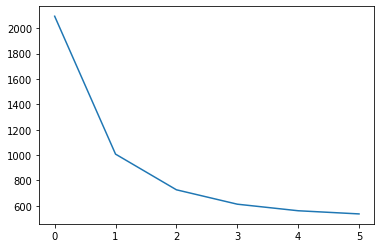

In [11]:
# plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(loc='upper right')
plt.show()

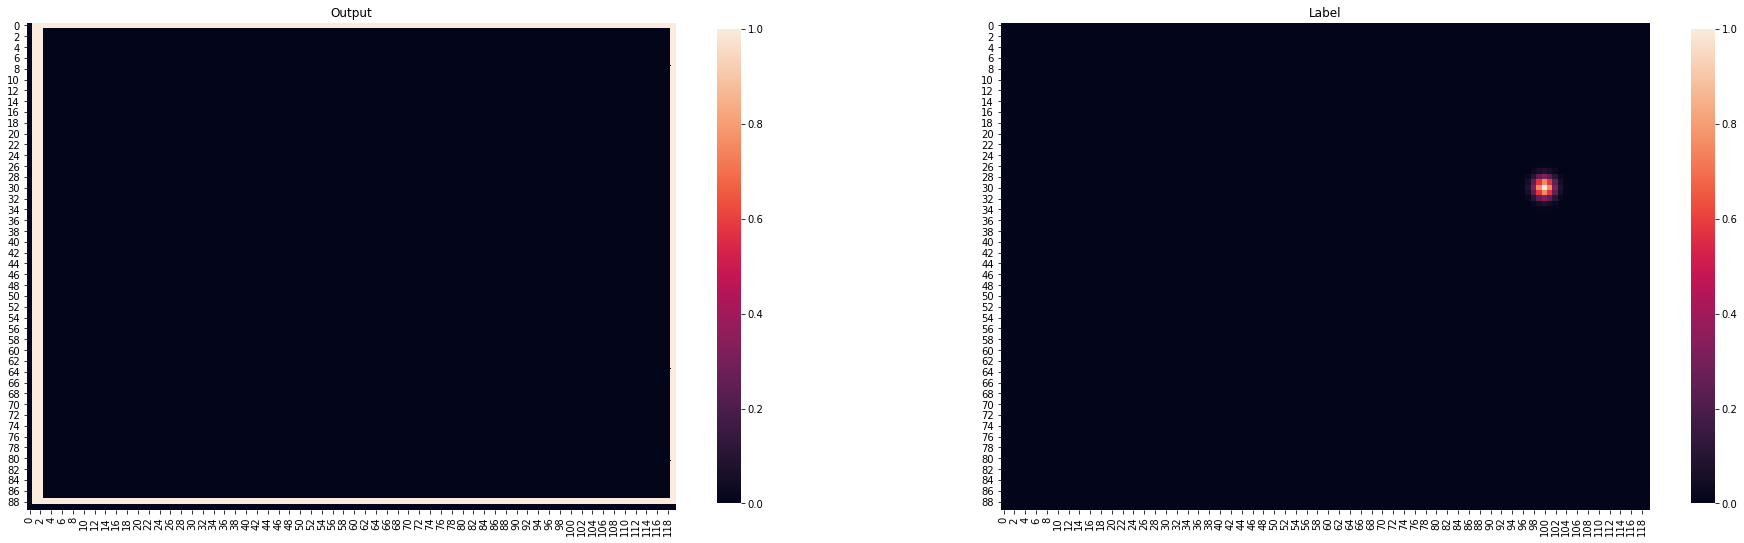

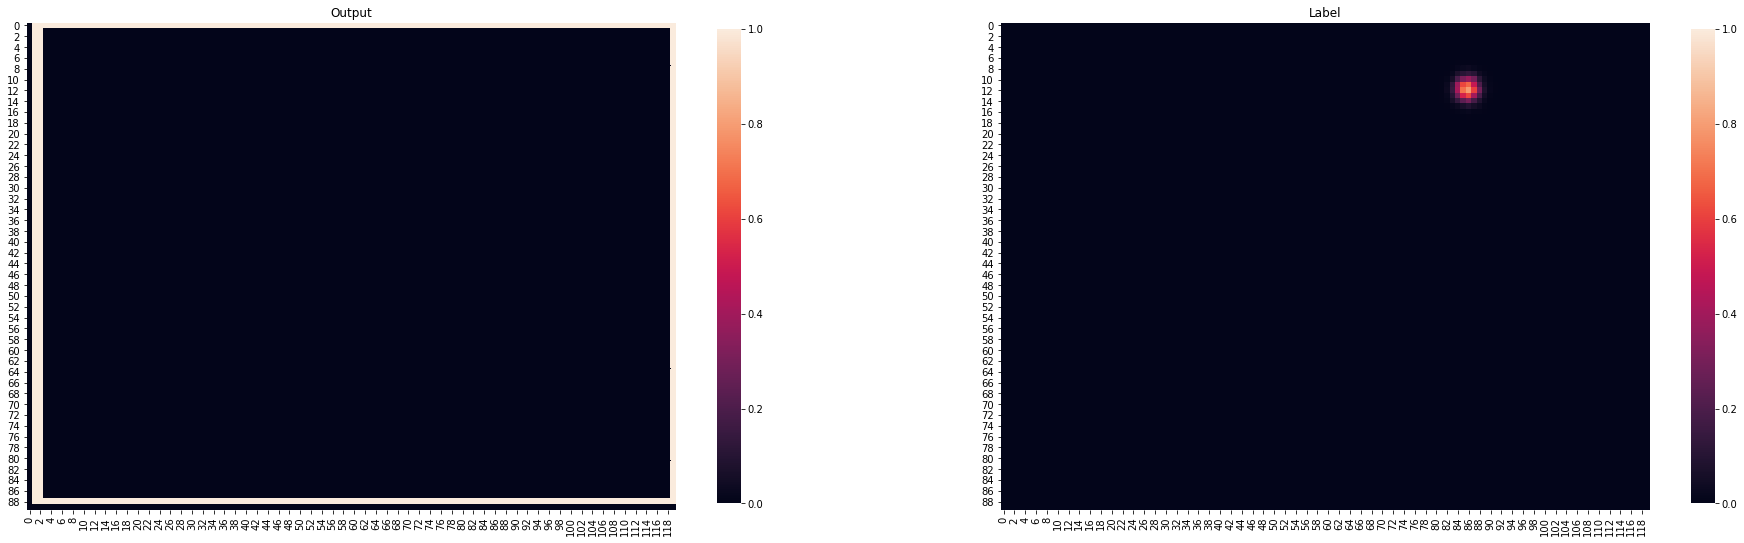

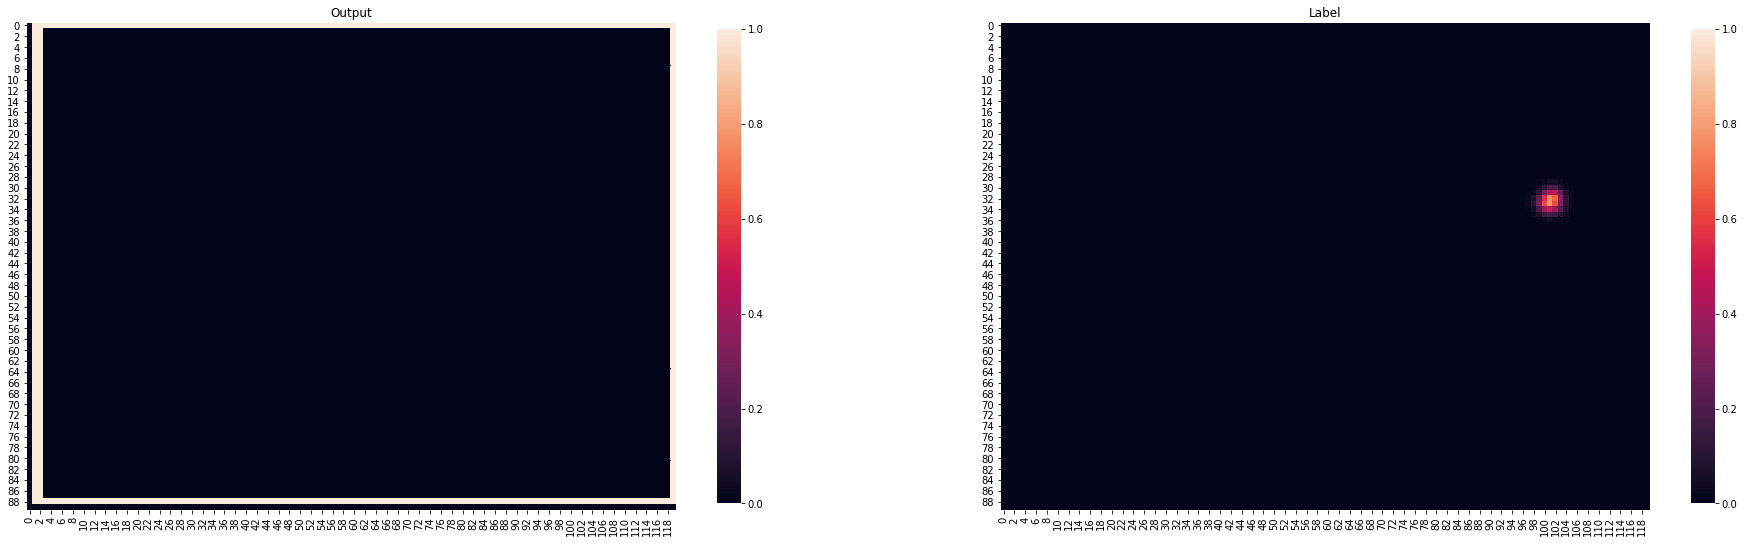

Average test loss:  535.30536
Testing completed


In [8]:
# Define the testing loop and output some heatmaps
# to estimate the performance of the CNN

def test():
    test_loss = 0
    num_test_samples = 3
    with torch.no_grad():
        for idx, (test_inputs, test_labels) in enumerate(dataloaders['train'], 0):
            if idx >= num_test_samples:
                break
            else:
                output = net(test_inputs.to(device)).reshape(batch_size, output_height, output_width)
                loss = loss_fn(output.cpu(), test_labels[0].cpu())
                output = output[0].reshape(output_height, output_width).cpu().detach().numpy()
                test_labels = test_labels[0].reshape(output_height, output_width)
                test_loss += loss

                fig = plt.figure(figsize = (32,24))
                ax1 = fig.add_subplot(2, 2, 1)
                ax1.set_title('Output')
                ax2 = fig.add_subplot(2, 2, 2)
                ax2.set_title('Label')

                sns.heatmap(output, vmin=0, vmax=1, ax=ax1, square=True, cbar_kws={'shrink': .8})
                sns.heatmap(test_labels, vmin=0, vmax=1, ax=ax2, square=True, cbar_kws={'shrink': .8})
                plt.show()
        
        test_loss = test_loss/num_test_samples
        print('Average test loss: ' ,test_loss.numpy())
        print('Testing completed')
test()